## Figures for thesis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import json
import glob
import pickle
import re
from aif360.sklearn.metrics import statistical_parity_difference, disparate_impact_ratio, \
    average_odds_difference, equal_opportunity_difference

In [4]:
# directory management
wdir = os.getcwd()
udir = os.path.join(os.path.split(wdir)[0], "utils")
ddir = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data", "rawdata")
ddir2 = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data", "aggregated")
fdir = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_figures")
if not os.path.exists(fdir):
  # Create a figures directory because it does not exist
  os.makedirs(fdir)
  print("Figures directory has been created!")

json_file_path = os.path.join(udir,'tasks_metadata.json')
with open(json_file_path, 'r') as j:
    task_infos = json.loads(j.read())

## Plots

### Distribution of age across states for each year

In [5]:
# get all files for year y
year=2014
task='ACSEmployment'
data_file_paths = glob.glob(os.path.join(ddir, str(year), '1-Year') + f'/{str(year)}*_{task}.csv')
data_file_paths

['C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\fair_ml_thesis_data\\rawdata\\2014\\1-Year\\2014_AK_ACSEmployment.csv',
 'C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\fair_ml_thesis_data\\rawdata\\2014\\1-Year\\2014_AL_ACSEmployment.csv',
 'C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\fair_ml_thesis_data\\rawdata\\2014\\1-Year\\2014_AR_ACSEmployment.csv',
 'C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\fair_ml_thesis_data\\rawdata\\2014\\1-Year\\2014_AZ_ACSEmployment.csv',
 'C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\fair_ml_thesis_data\\rawdata\\2014\\1-Year\\2014_CA_ACSEmployment.csv',
 'C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\fair_ml_thesis_data\\rawdata\\2014\\1-Year\\2014_CO_ACSEmployment.csv',
 'C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\fair_ml_thesis_data\\rawdata\\2014\\1-Year\\2014_CT_ACSEmployment.csv',
 'C:\\Users\\sarab\\Desktop\\Data_Science_MSc\\master_thesis\\

In [6]:
state_pattern = re.compile(r"_([^_]+)_")
dfs = []
for year in [2014,2015,2016,2017,2018]:
    data_file_paths = glob.glob(os.path.join(ddir, str(year), '1-Year') + f'/{str(year)}*_{task}.csv')
    for p in data_file_paths:

        # load data and change RAC1P values
        df = pd.read_csv(p)
        for c in task_infos['tasks'][1]['columns']:
            df.loc[:,c] = df.loc[:,c].astype(int)

        # age between 16 and 90
        df = df[df['AGEP'].between(16,90)]
        df['RAC1P'] = pd.to_numeric(df['RAC1P'])
        df.loc[df['RAC1P'] > 2, 'RAC1P'] = 3
        print(year, state_pattern.findall(p)[-1])
        df['STATE']= state_pattern.findall(p)[-1]
        df['YEAR']= year

        dfs.append(df)

df1 = pd.concat(dfs,ignore_index=True)

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 AK
2014 AL
2014 AR


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 AZ


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 CA
2014 CO
2014 CT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 DE


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 FL
2014 GA
2014 HI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 IA
2014 ID


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 IL
2014 IN
2014 KS


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 KY
2014 LA
2014 MA


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 MD
2014 ME
2014 MI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 MN
2014 MO
2014 MS
2014 MT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 NC
2014 ND
2014 NE
2014 NH
2014 NJ


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 NM
2014 NV


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 NY
2014 OH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 OK
2014 OR


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 PA
2014 RI
2014 SC
2014 SD


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 TN


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2014 TX
2014 UT
2014 VA
2014 VT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2014 WA
2014 WI
2014 WV
2014 WY
2015 AK


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 AL
2015 AR
2015 AZ


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 CA
2015 CO
2015 CT
2015 DE


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 FL
2015 GA
2015 HI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 IA
2015 ID


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2015 IL
2015 IN
2015 KS


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 KY
2015 LA
2015 MA


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 MD
2015 ME
2015 MI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 MN
2015 MO
2015 MS
2015 MT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 NC
2015 ND
2015 NE
2015 NH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 NJ
2015 NM
2015 NV


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 NY
2015 OH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2015 OK
2015 OR


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 PA
2015 RI
2015 SC
2015 SD


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2015 TN


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2015 TX
2015 UT
2015 VA
2015 VT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2015 WA
2015 WI
2015 WV
2015 WY
2016 AK


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 AL
2016 AR
2016 AZ


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2016 CA
2016 CO
2016 CT
2016 DE


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 FL
2016 GA
2016 HI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 IA
2016 ID


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2016 IL
2016 IN
2016 KS


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 KY
2016 LA
2016 MA


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 MD
2016 ME
2016 MI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2016 MN
2016 MO
2016 MS
2016 MT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 NC
2016 ND
2016 NE
2016 NH
2016 NJ


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 NM
2016 NV


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2016 NY
2016 OH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 OK
2016 OR


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 PA
2016 RI
2016 SC
2016 SD


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2016 TN


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2016 TX
2016 UT
2016 VA
2016 VT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2016 WA
2016 WI
2016 WV
2016 WY
2017 AK


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 AL
2017 AR
2017 AZ


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 CA
2017 CO
2017 CT
2017 DE


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 FL
2017 GA


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 HI
2017 IA
2017 ID


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 IL
2017 IN
2017 KS


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 KY
2017 LA
2017 MA


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 MD
2017 ME
2017 MI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 MN
2017 MO
2017 MS
2017 MT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 NC
2017 ND
2017 NE
2017 NH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 NJ
2017 NM
2017 NV


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2017 NY
2017 OH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 OK
2017 OR
2017 PA
2017 RI
2017 SC
2017 SD
2017 TN


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 TX
2017 UT
2017 VA
2017 VT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2017 WA
2017 WI
2017 WV
2017 WY
2018 AK


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 AL
2018 AR
2018 AZ


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2018 CA
2018 CO
2018 CT
2018 DE


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 FL
2018 GA
2018 HI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 IA
2018 ID
2018 IL


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 IN
2018 KS
2018 KY


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 LA
2018 MA
2018 MD


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 ME
2018 MI


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 MN
2018 MO
2018 MS
2018 MT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 NC
2018 ND
2018 NE
2018 NH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 NJ
2018 NM
2018 NV


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2018 NY
2018 OH


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 OK
2018 OR


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 PA
2018 RI
2018 SC
2018 SD


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2018 TN


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



2018 TX
2018 UT
2018 VA
2018 VT


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

2018 WA
2018 WI
2018 WV
2018 WY


C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_8040\2656564626.py:10: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12808427 entries, 0 to 12808426
Data columns (total 20 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   AGEP        int32 
 2   SCHL        int32 
 3   MAR         int32 
 4   RELP        int32 
 5   DIS         int32 
 6   ESP         int32 
 7   CIT         int32 
 8   MIG         int32 
 9   MIL         int32 
 10  ANC         int32 
 11  NATIVITY    int32 
 12  DEAR        int32 
 13  DEYE        int32 
 14  DREM        int32 
 15  SEX         int32 
 16  RAC1P       int32 
 17  ESR         int32 
 18  STATE       object
 19  YEAR        int64 
dtypes: int32(17), int64(2), object(1)
memory usage: 1.1+ GB


In [34]:
df1['STATE'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI',
       'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

### Class counts as a function of sex and race over the years - ACSEmployment

In [8]:
df1.groupby(by=['YEAR','STATE','SEX','RAC1P'])['ESR'].value_counts(normalize=True).to_frame('Proportion (%)')\
    .reset_index()

,YEAR,STATE,SEX,RAC1P,ESR,Proportion (%)
0,2014,AK,1,1,1,0.625727
1,2014,AK,1,1,0,0.374273
2,2014,AK,1,2,1,0.535714
3,2014,AK,1,2,0,0.464286
4,2014,AK,1,3,0,0.544700
...,...,...,...,...,...,...
2995,2018,WY,2,1,0,0.450165
2996,2018,WY,2,2,0,0.500000
2997,2018,WY,2,2,1,0.500000
2998,2018,WY,2,3,0,0.542289


In [9]:
df1.loc[df1['SEX'] == 1, 'SEX'] = 'Male'
df1.loc[df1['SEX'] == 2, 'SEX'] = 'Female'

df1.loc[df1['RAC1P'] == 1, 'RAC1P'] = 'White'
df1.loc[df1['RAC1P'] == 2, 'RAC1P'] = 'Black'
df1.loc[df1['RAC1P'] == 3, 'RAC1P'] = 'Other'

df1.loc[df1['ESR'] == 1, 'ESR'] = 'Employed'
df1.loc[df1['ESR'] == 0, 'ESR'] = 'Not Employed'

In [10]:
df1.groupby(by=['YEAR','STATE','SEX'])['ESR'].value_counts()

YEAR  STATE  SEX     ESR         
2014  AK     Female  Employed         1301
                     Not Employed     1085
             Male    Employed         1492
                     Not Employed     1196
      AL     Female  Not Employed    11521
                                     ...  
2018  WV     Male    Employed         3681
      WY     Female  Employed         1261
                     Not Employed     1067
             Male    Employed         1408
                     Not Employed      898
Name: ESR, Length: 1000, dtype: int64

In [12]:
y=2014
esr_df = df1.groupby(by=['YEAR','STATE','ESR'])['SEX'].value_counts(normalize=True).to_frame('Proportion').reset_index()
esr_df

,YEAR,STATE,ESR,SEX,Proportion
0,2014,AK,Employed,Male,0.534193
1,2014,AK,Employed,Female,0.465807
2,2014,AK,Not Employed,Male,0.524331
3,2014,AK,Not Employed,Female,0.475669
4,2014,AL,Employed,Male,0.519428
...,...,...,...,...,...
995,2018,WV,Not Employed,Male,0.465353
996,2018,WY,Employed,Male,0.527538
997,2018,WY,Employed,Female,0.472462
998,2018,WY,Not Employed,Female,0.543003


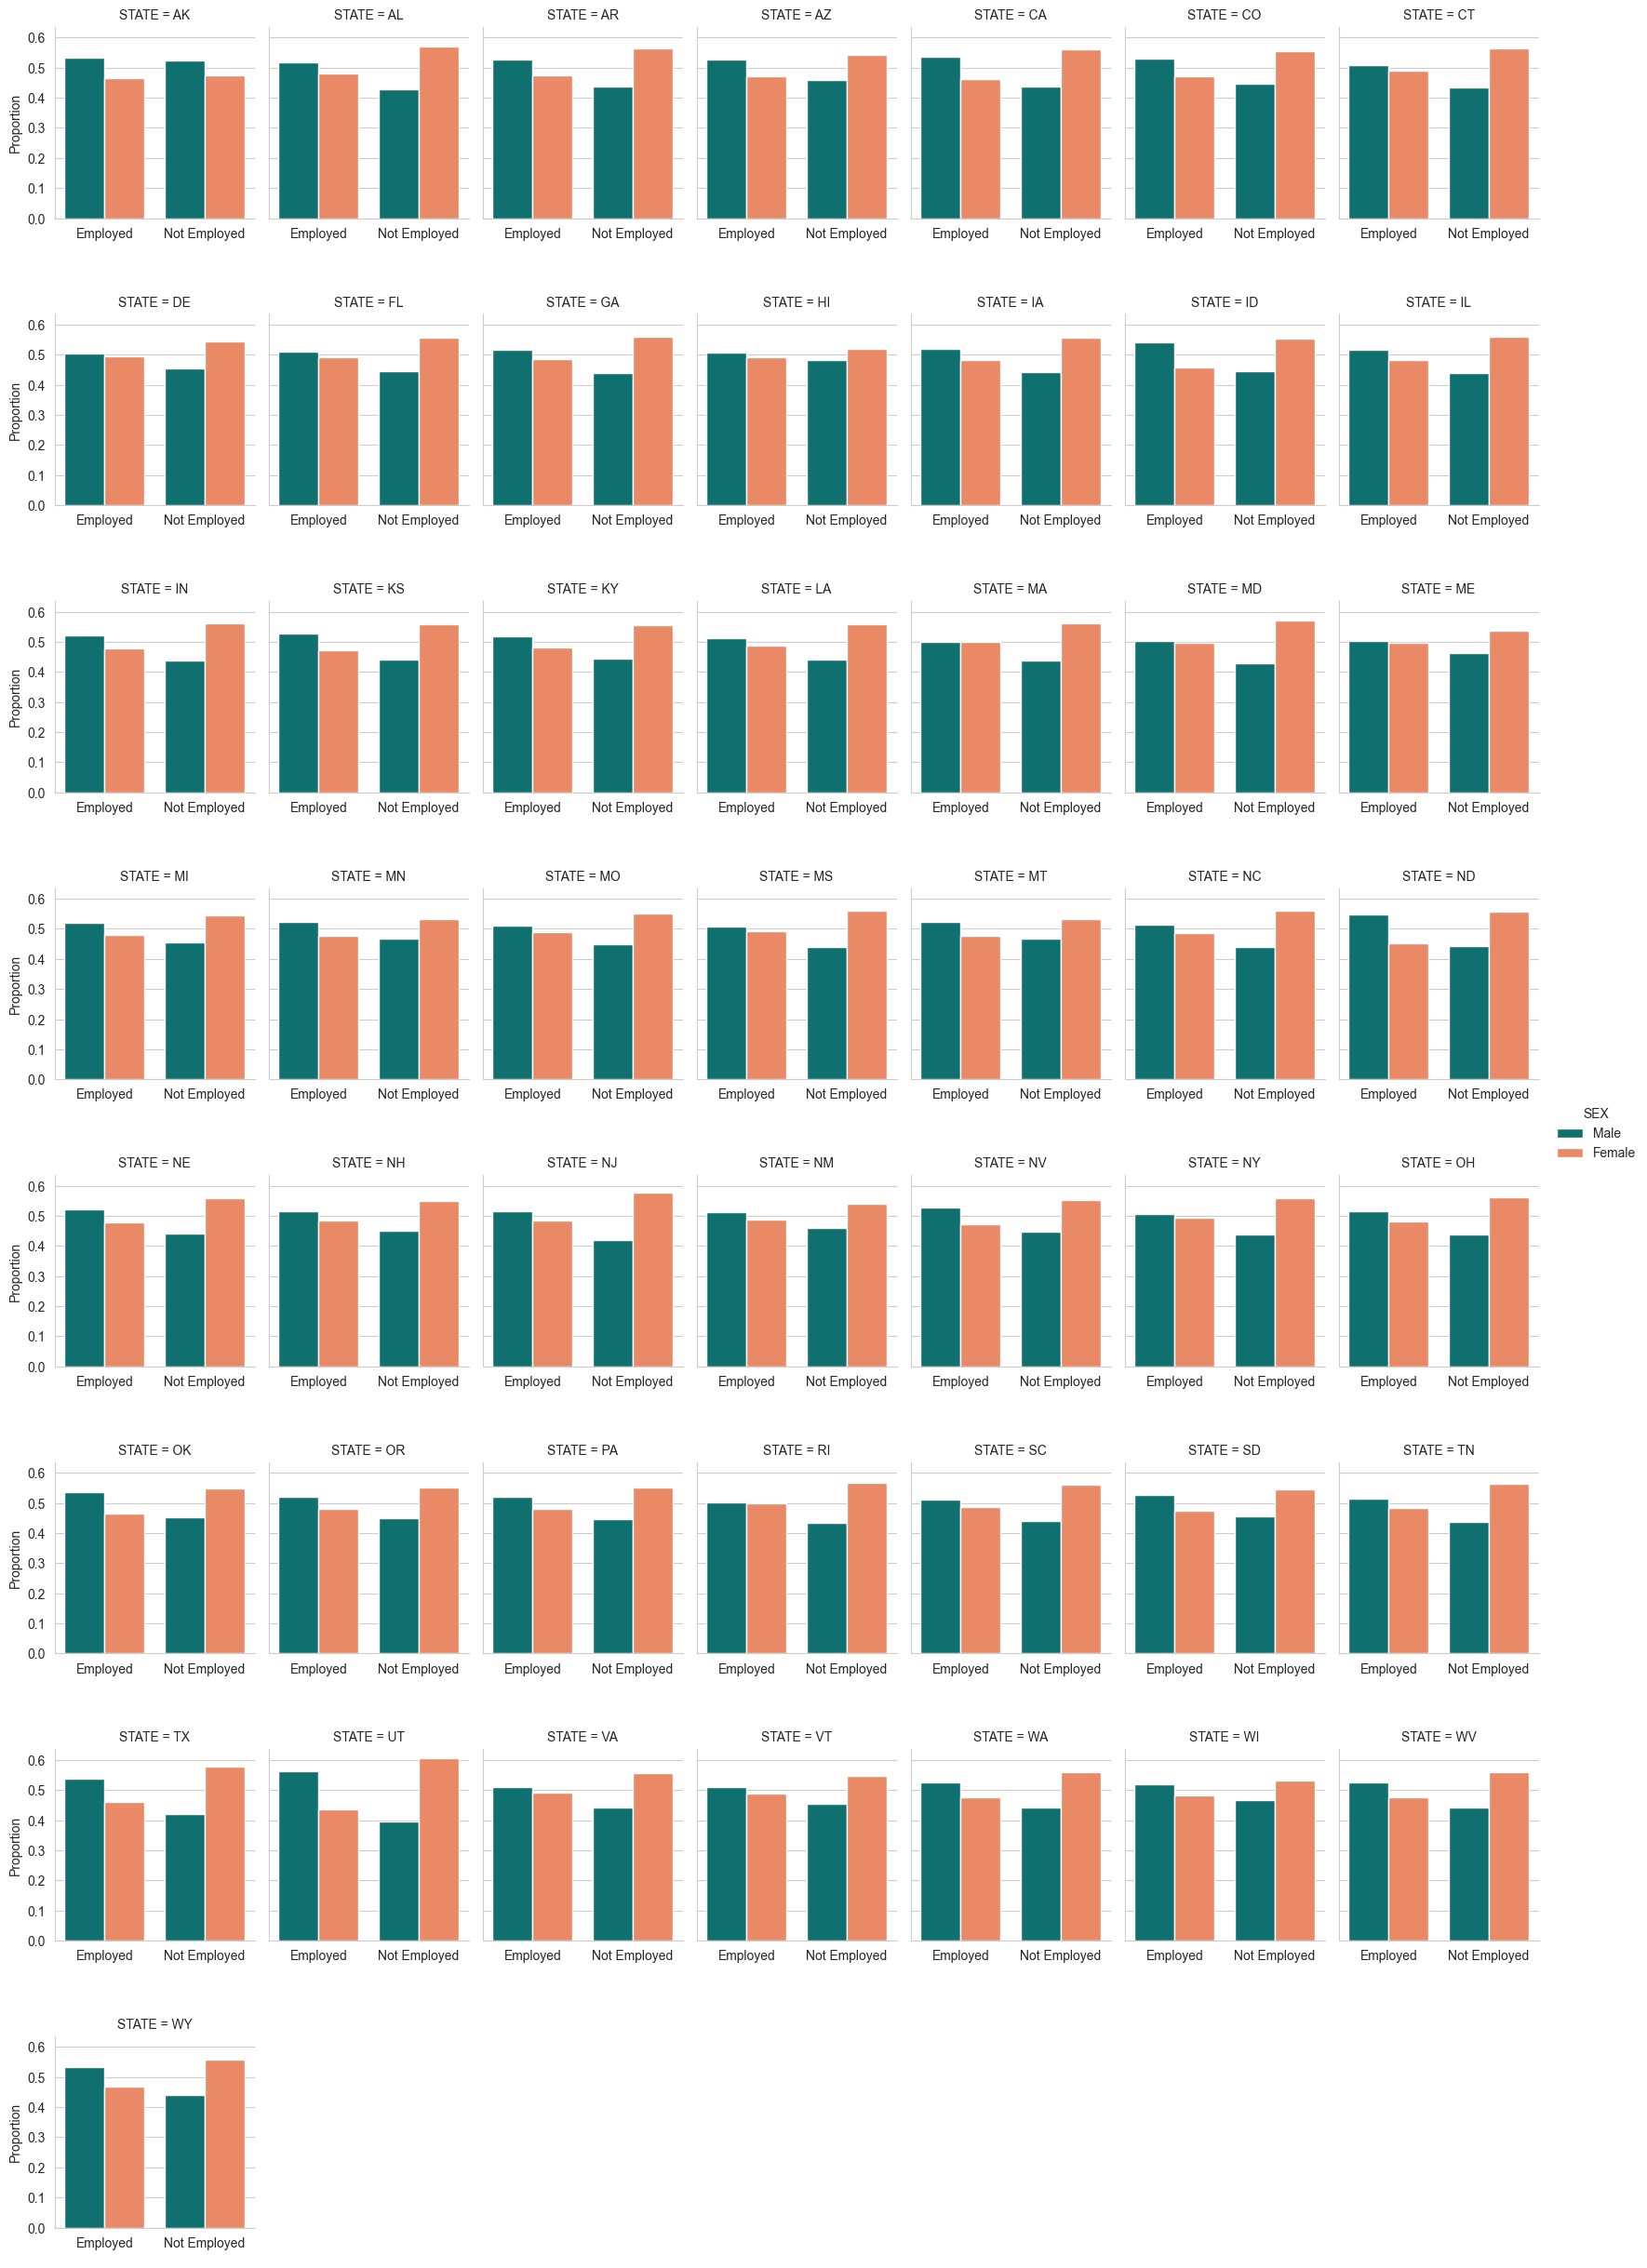

In [13]:
# plot
g = sns.catplot(data=esr_df[esr_df['YEAR']==y], x="ESR",y='Proportion', hue="SEX", col="STATE",col_wrap=7,kind="bar",
            errorbar=None,
            height=6,palette={'Female': 'coral', 'Male': 'teal'}, aspect=.4) #4,0.6
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("")
    ax.set_ylabel("Proportion")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)
plt.savefig(os.path.join(fdir,task,f'new_ESR_distribution_dependent_on_SEX_{task}_{y}.pdf'),format='pdf',dpi=300)

In [14]:
esr_df2 = df1.groupby(by=['YEAR','STATE','ESR'])['RAC1P'].value_counts(normalize=True).to_frame('Proportion')\
    .reset_index()
esr_df2

,YEAR,STATE,ESR,RAC1P,Proportion
0,2014,AK,Employed,White,0.625134
1,2014,AK,Employed,Other,0.361260
2,2014,AK,Employed,Black,0.013605
3,2014,AK,Not Employed,White,0.501534
4,2014,AK,Not Employed,Other,0.481806
...,...,...,...,...,...
1495,2018,WY,Employed,Other,0.071562
1496,2018,WY,Employed,Black,0.005995
1497,2018,WY,Not Employed,White,0.893639
1498,2018,WY,Not Employed,Other,0.102799


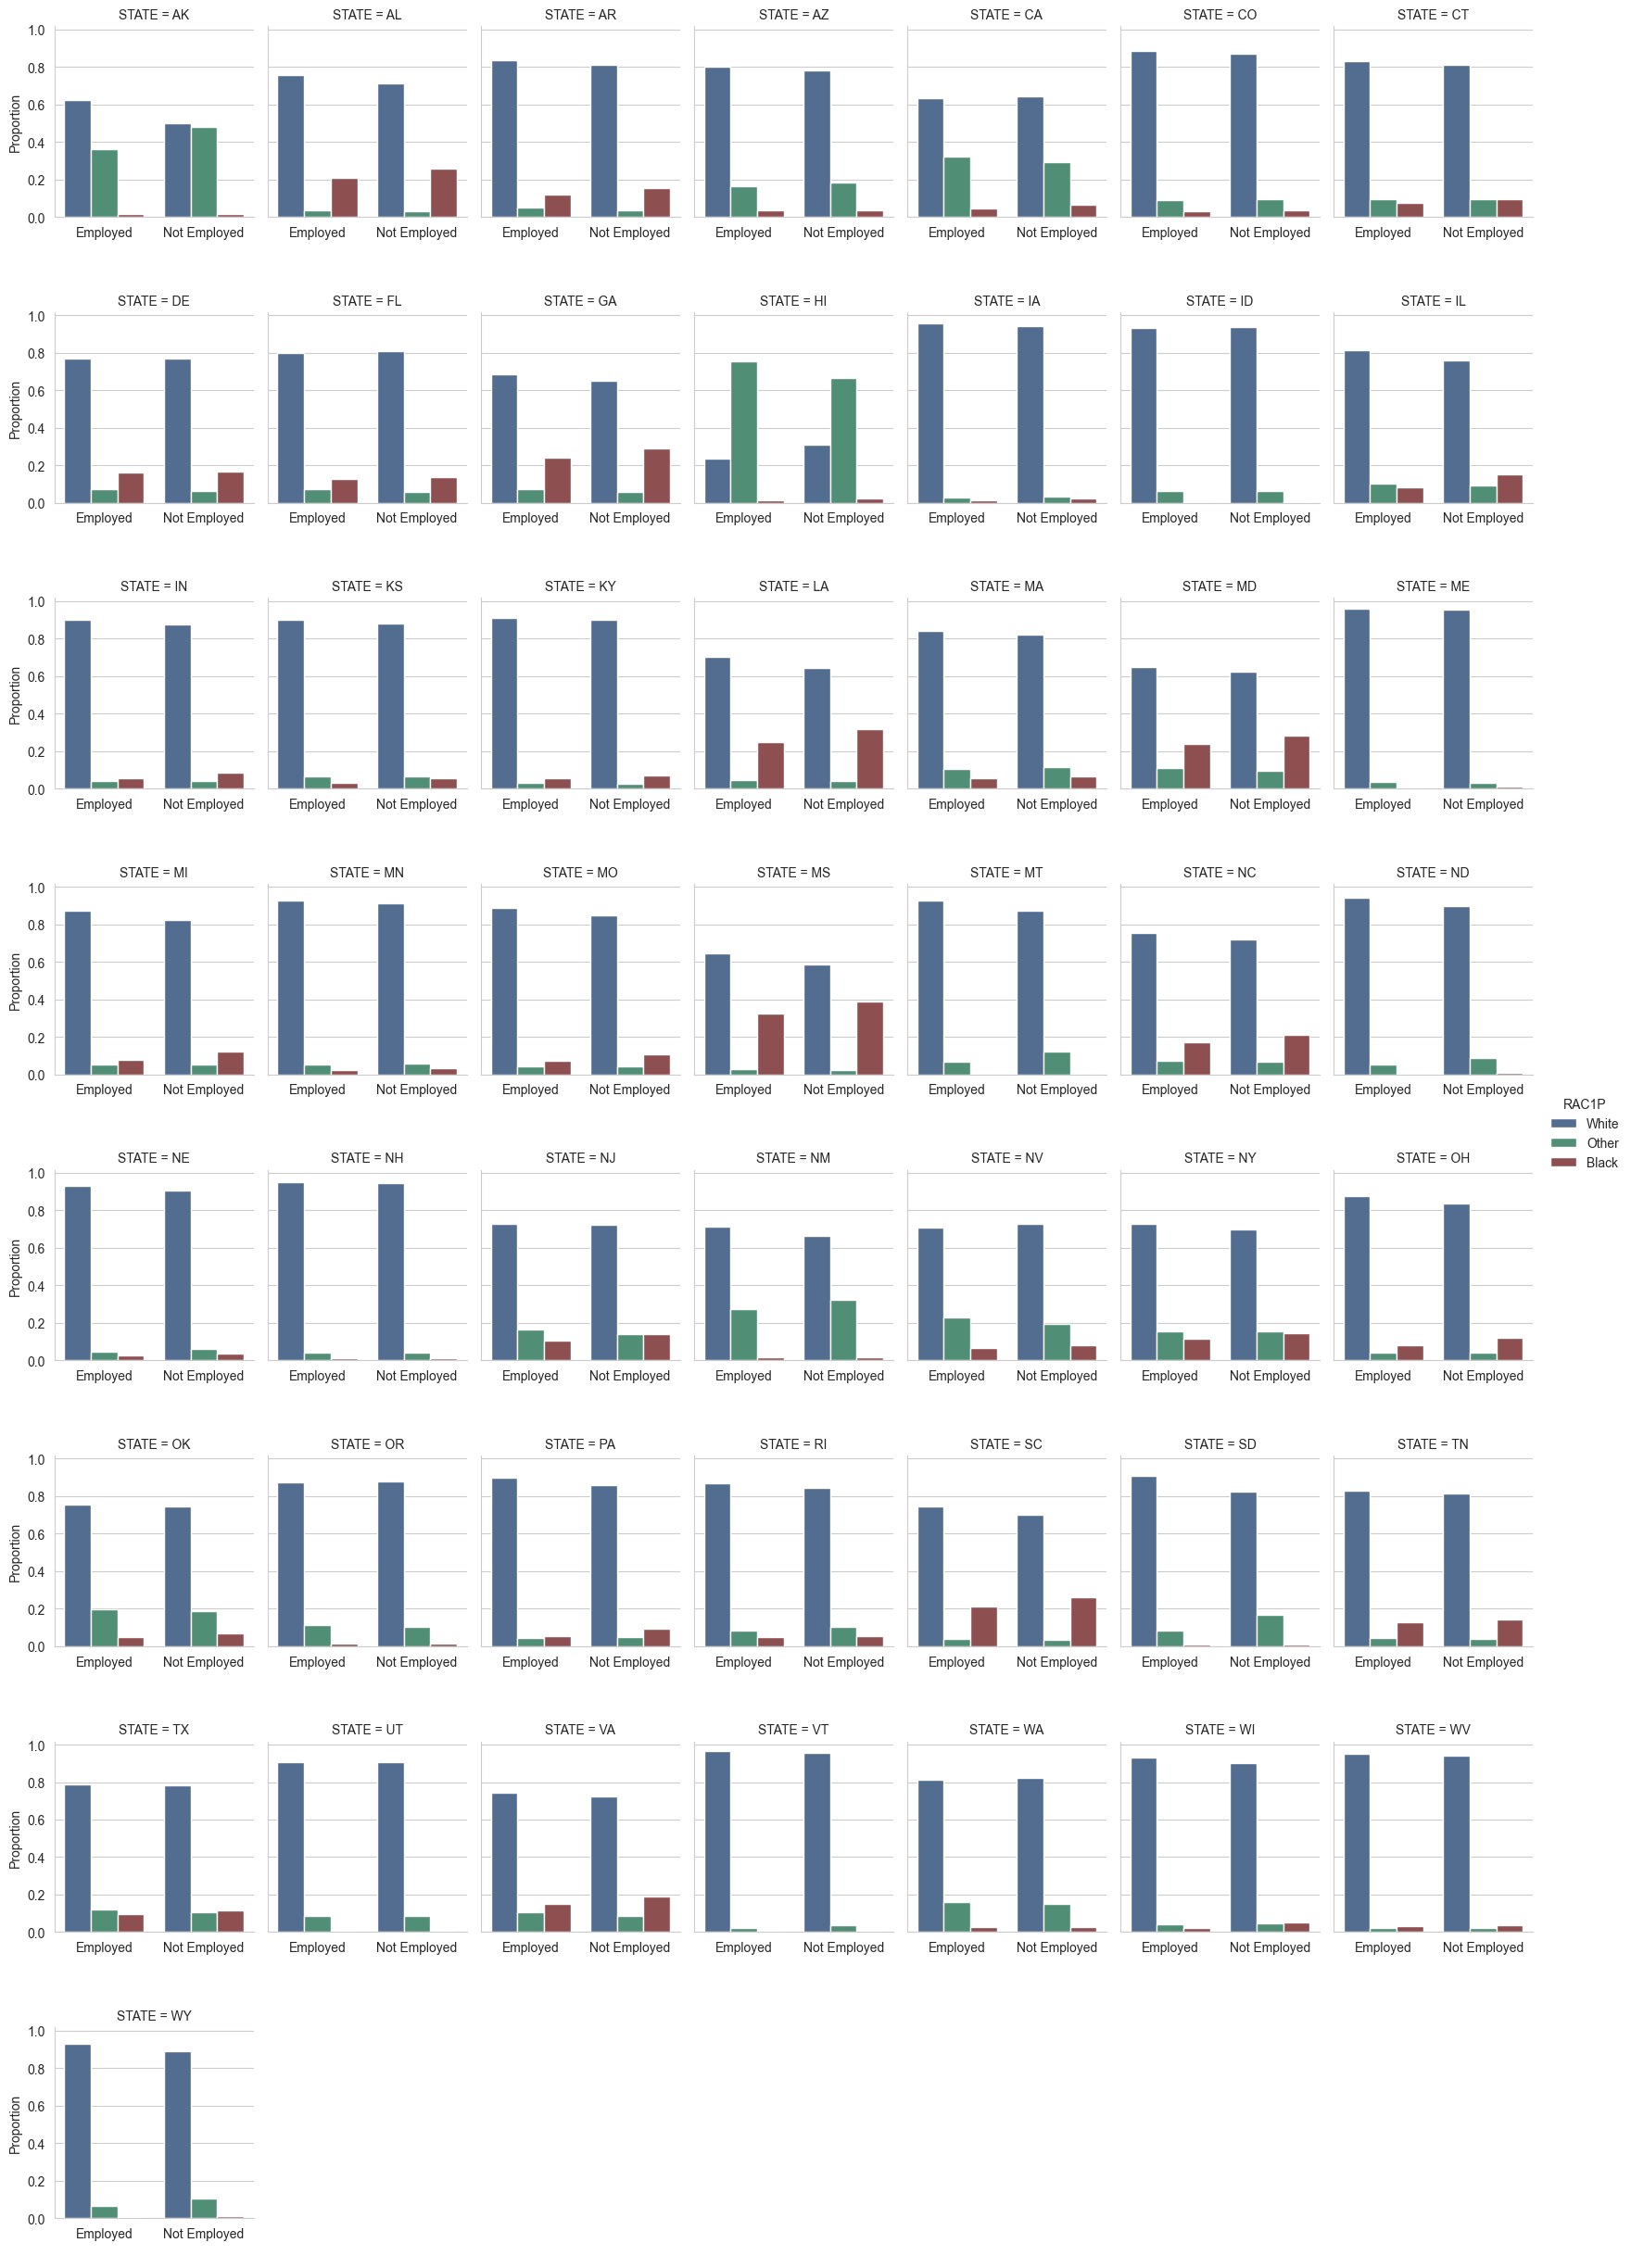

In [15]:
g = sns.catplot(data=esr_df2[esr_df2['YEAR']==2014], x="ESR",y='Proportion', hue="RAC1P", col="STATE",col_wrap=7,
            kind="bar",
            errorbar=None,
            height=6,palette={'White':'#476C9B','Black':'#984447','Other':'#469978'}, aspect=.4)
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("")
    ax.set_ylabel("Proportion")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)

plt.savefig(os.path.join(fdir,task,f'new_ESR_distribution_dependent_on_RAC1P_{task}_{y}.pdf'),format='pdf',dpi=300)

In [16]:
# employment status
SCHL= {
    1: "No schooling completed",
    2: "Nursery school, preschool",
    3:"Kindergarten",
    4:"Grade 1",
    5:"Grade 2",
    6:"Grade 3",
    7:"Grade 4",
    8:"Grade 5",
    9:"Grade 6",
    10:"Grade 7",
    11:"Grade 8",
    12:"Grade 9",
    13:"Grade 10",
    14:"Grade 11",
    15:"Grade 12 - no diploma",
    16:"Regular high school diploma",
    17:"GED or alternative credential",
    18:"Some college, but less than 1 year",
    19:"1 or more years of college credit, no degree",
    20:"Associate degree",
    21:"Bachelor degree",
    22:"Master degree",
    23:"Professional degree beyond a bachelor degree",
    24:"Doctorate degree"}
#df1.loc[:, 'SCHL'] = df1['SCHL'].astype(np.int64)
df1['SCHL'] = df1['SCHL'].map(SCHL)
edu_df = df1.groupby(by=['YEAR','STATE','SEX','RAC1P'])['SCHL'].value_counts(normalize=True).to_frame('Proportion')\
    .reset_index()
edu_df

,YEAR,STATE,SEX,RAC1P,SCHL,Proportion
0,2014,AK,Female,Black,Regular high school diploma,0.300000
1,2014,AK,Female,Black,"1 or more years of college credit, no degree",0.200000
2,2014,AK,Female,Black,Associate degree,0.200000
3,2014,AK,Female,Black,"Some college, but less than 1 year",0.100000
4,2014,AK,Female,Black,Doctorate degree,0.050000
...,...,...,...,...,...,...
31205,2018,WY,Male,White,Grade 6,0.004284
31206,2018,WY,Male,White,No schooling completed,0.003808
31207,2018,WY,Male,White,Grade 7,0.000952
31208,2018,WY,Male,White,Grade 3,0.000476


In [17]:
edu_df[edu_df['STATE']=='VT']

,YEAR,STATE,SEX,RAC1P,SCHL,Proportion
5698,2014,VT,Female,Black,"1 or more years of college credit, no degree",0.133333
5699,2014,VT,Female,Black,Bachelor degree,0.133333
5700,2014,VT,Female,Black,Grade 11,0.133333
5701,2014,VT,Female,Black,No schooling completed,0.133333
5702,2014,VT,Female,Black,Regular high school diploma,0.133333
...,...,...,...,...,...,...
30759,2018,VT,Male,White,Grade 8,0.008853
30760,2018,VT,Male,White,Grade 7,0.001155
30761,2018,VT,Male,White,Grade 6,0.000770
30762,2018,VT,Male,White,Grade 4,0.000385


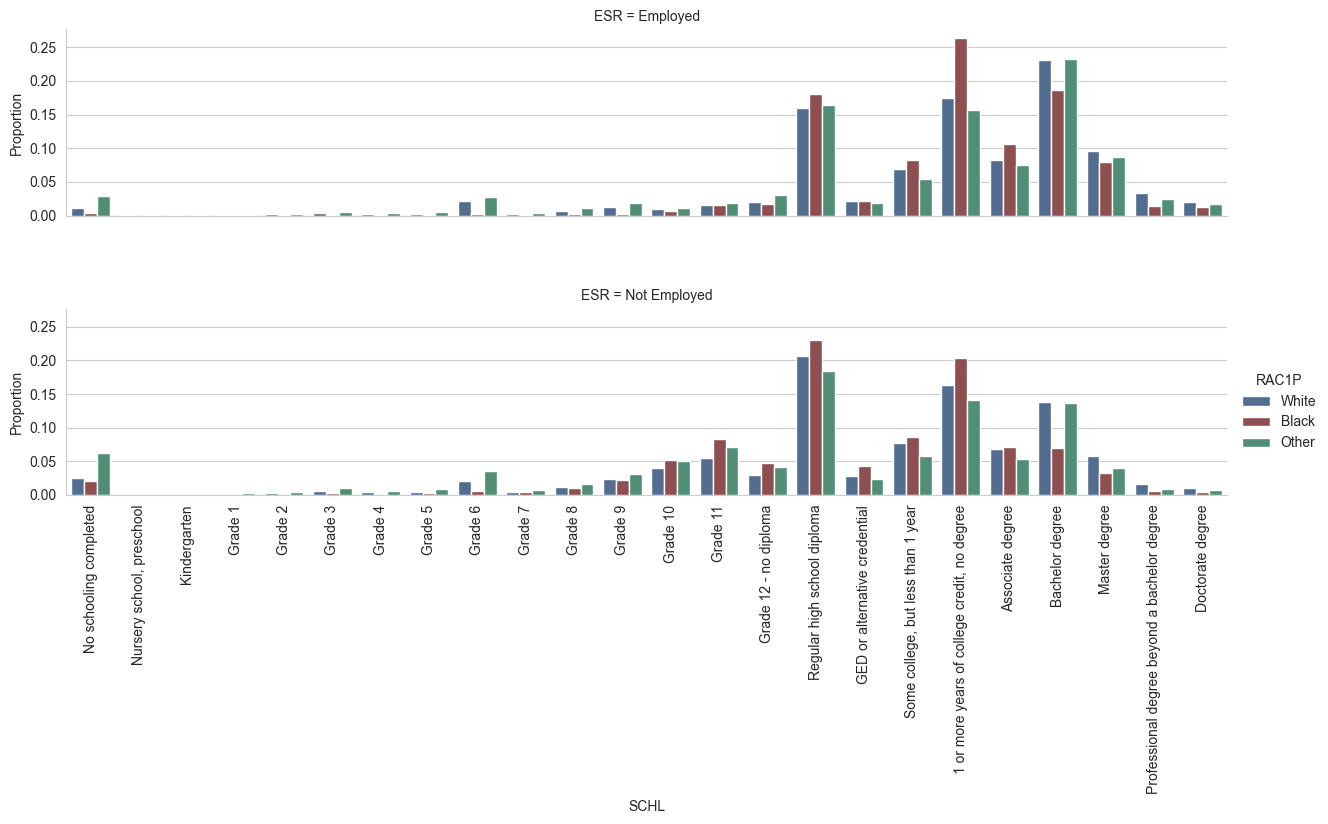

In [18]:
edu_df2 = df1.groupby(by=['YEAR','STATE','RAC1P','ESR'])['SCHL'].value_counts(normalize=True).to_frame\
    ('Proportion')\
    .reset_index()


g = sns.catplot(data=edu_df2[(edu_df2['YEAR']==2014)&(edu_df2['STATE'].isin(['CA']))],
                x="SCHL",
                y='Proportion',
                hue="RAC1P",
                row='ESR',
                order=[ "No schooling completed","Nursery school, preschool","Kindergarten","Grade 1","Grade 2",
"Grade 3",
"Grade 4",
"Grade 5",
"Grade 6",
"Grade 7",
 "Grade 8",
"Grade 9",
"Grade 10",
"Grade 11",
    "Grade 12 - no diploma",
   "Regular high school diploma",
   "GED or alternative credential",
  "Some college, but less than 1 year",
    "1 or more years of college credit, no degree",
    "Associate degree",
    "Bachelor degree",
"Master degree",
"Professional degree beyond a bachelor degree",
"Doctorate degree"], hue_order=['White','Black','Other'],palette={'White':'#476C9B','Black':'#984447',
                                                                  'Other':'#469978'},
            kind='bar', errorbar=None, aspect=2.5)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5,hspace=0.5)

In [55]:
edu_df2[(edu_df2['YEAR']==2014)&(edu_df2['STATE'].isin(['VT']))]

,YEAR,STATE,RAC1P,ESR,SCHL,Proportion
5644,2014,VT,Other,Employed,Regular high school diploma,0.233766
5645,2014,VT,Other,Employed,Bachelor degree,0.220779
5646,2014,VT,Other,Employed,"1 or more years of college credit, no degree",0.207792
5647,2014,VT,Other,Employed,Master degree,0.103896
5648,2014,VT,Other,Employed,"Some college, but less than 1 year",0.103896
...,...,...,...,...,...,...
5721,2014,VT,White,Not Employed,Grade 7,0.004356
5722,2014,VT,White,Not Employed,Grade 6,0.002904
5723,2014,VT,White,Not Employed,Grade 5,0.000968
5724,2014,VT,White,Not Employed,Grade 3,0.000484


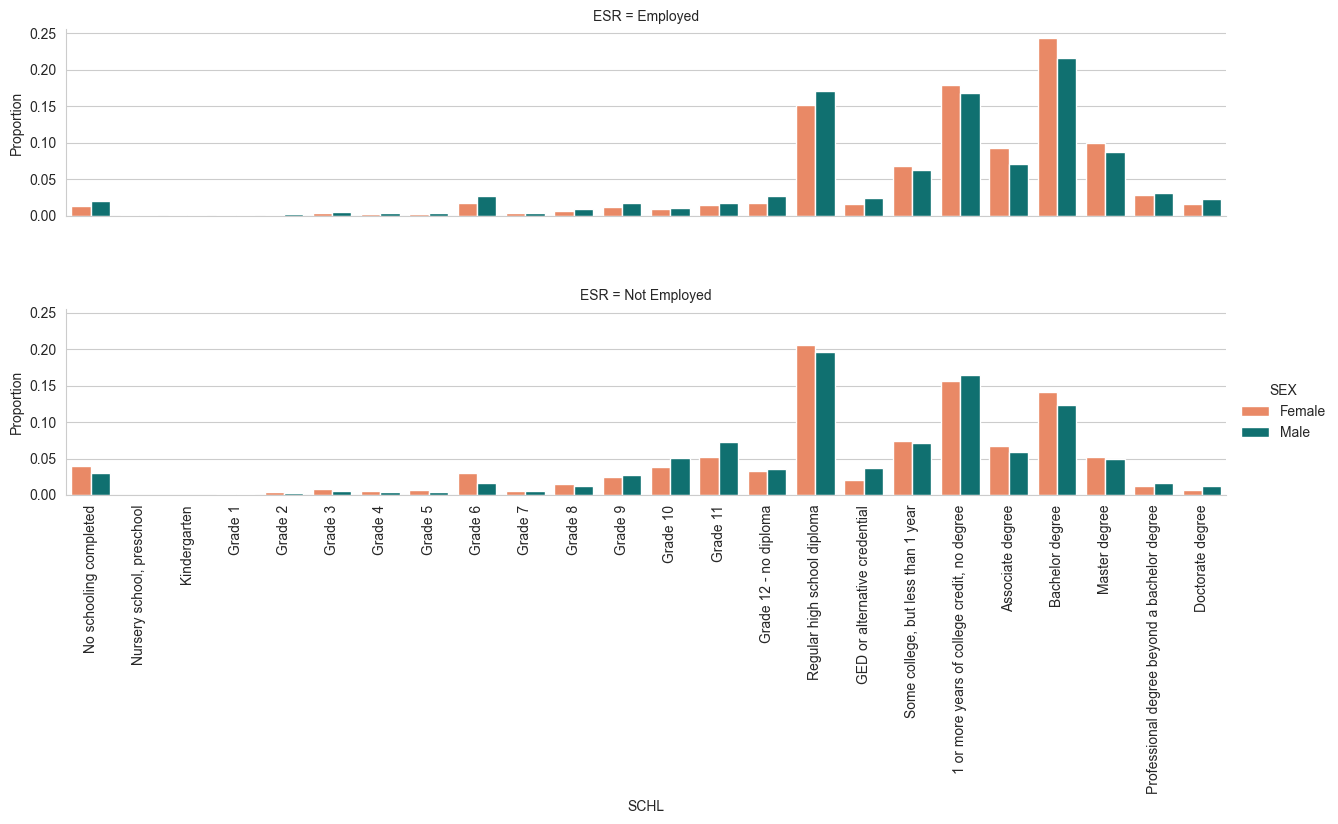

In [19]:
edu_df_sex = df1.groupby(by=['YEAR','STATE','SEX','ESR'])['SCHL'].value_counts(normalize=True).to_frame\
    ('Proportion')\
    .reset_index()

g = sns.catplot(data=edu_df_sex[(edu_df_sex['YEAR']==2014)&(edu_df_sex['STATE'].isin(['CA']))],
                x="SCHL",
                y='Proportion',
                hue="SEX",
                row='ESR',
                order=[ "No schooling completed","Nursery school, preschool","Kindergarten","Grade 1","Grade 2",
"Grade 3",
"Grade 4",
"Grade 5",
"Grade 6",
"Grade 7",
 "Grade 8",
"Grade 9",
"Grade 10",
"Grade 11",
    "Grade 12 - no diploma",
   "Regular high school diploma",
   "GED or alternative credential",
  "Some college, but less than 1 year",
    "1 or more years of college credit, no degree",
    "Associate degree",
    "Bachelor degree",
"Master degree",
"Professional degree beyond a bachelor degree",
"Doctorate degree"], hue_order=['Female','Male'],
                palette={'Female': 'coral', 'Male': 'teal'},
            kind='bar', errorbar=None, aspect=2.5)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5,hspace=0.5)

## Fairness metrics of original state data for each year (fairlearn metrics)

In [57]:
metricss = []

for y in range(2014,2019):
    data_files = glob.glob(os.path.join(ddir, str(y),'1-Year') + f'\*_ACSEmployment.csv')
    for d in data_files:

        state = os.path.split(d)[1][5:7]
        df = pd.read_csv(d, sep=',', index_col=0)

        for c in task_infos['tasks'][1]['columns']:
            df.loc[:,c] = df.loc[:,c].astype(int)

        # age between 16 and 90
        df = df[df['AGEP'].between(16,90)]
        df['RAC1P'] = pd.to_numeric(df['RAC1P'])
        df.loc[df['RAC1P'] > 2, 'RAC1P'] = 3
        df.set_index(['SEX', 'RAC1P'], inplace=True)

        metricss.append([
            y,
            state,
            statistical_parity_difference(y_true = df['ESR'], prot_attr=['SEX'], priv_group=1, pos_label=1),
            statistical_parity_difference(y_true = df['ESR'], prot_attr=['RAC1P'], priv_group=1, pos_label=1),
            disparate_impact_ratio(y_true = df['ESR'], prot_attr=['SEX'], priv_group=1, pos_label=1),
            disparate_impact_ratio(y_true = df['ESR'], prot_attr=['RAC1P'], priv_group=1, pos_label=1)
        ])


metrics_df = pd.DataFrame(metricss,columns = ['year','state','spd_sex','spd_rac','dir_sex','dir_rac'])
metrics_df


C:\Users\sarab\AppData\Local\Temp\ipykernel_13680\1016788766.py:11: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_13680\1016788766.py:11: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\sarab\AppData\Local\Temp\ipykernel_13680\1016788766.py:11: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, new

,year,state,spd_sex,spd_rac,dir_sex,dir_rac
0,2014,AK,-0.009795,-0.124757,0.982352,0.793501
1,2014,AL,-0.090434,-0.057677,0.830055,0.884629
2,2014,AR,-0.089964,-0.038768,0.831907,0.921731
3,2014,AZ,-0.069369,-0.028988,0.871155,0.943084
4,2014,CA,-0.098651,0.007044,0.832003,1.013181
...,...,...,...,...,...,...
245,2018,VT,-0.034794,-0.014605,0.943163,0.975457
246,2018,WA,-0.078551,0.041565,0.870107,1.074688
247,2018,WI,-0.045825,-0.080822,0.926778,0.867416
248,2018,WV,-0.057192,-0.074730,0.884482,0.841046


In [58]:
metrics_df.to_csv(os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data","results",'metrics','fairlearn_metrics_ACSEmployment.csv'),
                  sep=',')

In [63]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,
                    locationmode="USA-states", color='spd_sex', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_spd_sex.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"new_metrics_spd_sex.png"))

In [64]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,color_continuous_scale="Viridis",
                    locationmode="USA-states", color='spd_rac', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_spd_rac.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"new_metrics_spd_rac.png"))

In [65]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,color_continuous_scale="oranges",
                    locationmode="USA-states", color='dir_sex', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_dir_sex.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"new_metrics_dir_sex.png"))

In [66]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,color_continuous_scale="deep",
                    locationmode="USA-states", color='dir_rac', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_dir_rac.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"new_metrics_dir_rac.png"))